In [32]:
import pandas as pd
import joblib


data = pd.read_pickle("../data/PdM_merged_preprocessed.pkl")
#data = data[data['machineID'] == 1]
# Nur die Daten wo failure != 0
data = data[data['failure'] != 0]

scaler = joblib.load("../data/scaler.pkl")
# Umwandeln (inversiv) von volt, rotate, pressure, vibration, age 
data[['volt', 'rotate', 'pressure', 'vibration', 'age']] = scaler.inverse_transform(data[['volt', 'rotate', 'pressure', 'vibration', 'age']])

/home/EnzoZ/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Regelbasiert

In [33]:
from IPython.display import display

# Berechne die Mittelwerte der relevanten Spalten
mean_values = data[['volt', 'rotate', 'pressure', 'vibration']].mean()

# Setze die Schwellenwerte basierend auf den Mittelwerten
THRESHOLDS = {
    "volt_high": mean_values['volt'] * 1.10,
    "volt_low": mean_values['volt'] * 0.90,
    "rotate_high": mean_values['rotate'] * 1.10,
    "rotate_low": mean_values['rotate'] * 0.90,
    "pressure_high": mean_values['pressure'] * 1.10,
    "pressure_low": mean_values['pressure'] * 0.90,
    "vibration_high": mean_values['vibration'] * 1.10,
    "vibration_low": mean_values['vibration'] * 0.90,
}

def apply_rbs_with_dynamic_thresholds(data, thresholds):
    results = []
    for _, row in data.iterrows():
        rules_triggered = []
        if row['vibration'] > thresholds['vibration_high']:
            rules_triggered.append("High Vibration")
        elif row['vibration'] < thresholds['vibration_low']:
            rules_triggered.append("Low Vibration")
        if row['pressure'] > thresholds['pressure_high']:
            rules_triggered.append("High Pressure")
        elif row['pressure'] < thresholds['pressure_low']:
            rules_triggered.append("Low Pressure")
        if row['rotate'] > thresholds['rotate_high']:
            rules_triggered.append("High Rotation Speed")
        elif row['rotate'] < thresholds['rotate_low']:
            rules_triggered.append("Low Rotation Speed")
        if row['volt'] > thresholds['volt_high']:
            rules_triggered.append("High Voltage")
        elif row['volt'] < thresholds['volt_low']:
            rules_triggered.append("Low Voltage")
        
        # Summarize the diagnosis
        results.append(", ".join(rules_triggered) if rules_triggered else "No Issues")
    
    data['RBS_Diagnosis'] = results
    return data


rbs_results_dynamic = apply_rbs_with_dynamic_thresholds(data, THRESHOLDS)

# Display the first few rows with RBS diagnosis
display(rbs_results_dynamic.head())


,datetime,machineID,volt,rotate,pressure,vibration,errorID,failure,comp,model,age,volt_rotate,pressure_vibration,RBS_Diagnosis
96,2015-01-05 06:00:00,1,179.303153,499.777962,111.833028,52.383097,0,4,4,3,18.0,0.337255,0.272483,"High Vibration, High Rotation Speed"
97,2015-01-05 06:00:00,1,179.303153,499.777962,111.833028,52.383097,0,4,1,3,18.0,0.337255,0.272483,"High Vibration, High Rotation Speed"
1539,2015-03-06 06:00:00,1,198.257975,456.862342,89.333995,38.671900,0,1,1,3,18.0,0.365926,0.108685,"Low Vibration, Low Pressure, High Voltage"
2620,2015-04-20 06:00:00,1,180.050801,346.362480,105.661164,39.218055,0,2,2,3,18.0,0.195838,0.158827,Low Rotation Speed
4061,2015-06-19 06:00:00,1,187.673963,493.005160,105.334392,53.963961,0,4,1,3,18.0,0.364729,0.253514,"High Vibration, High Rotation Speed"


### Fallbasiert

In [35]:
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
from IPython.display import display

# Implement Case-Based Reasoning (CBR)
# Select relevant features for similarity computation
FEATURES = ['volt', 'rotate', 'pressure', 'vibration']

# Define a function to compute similarity (Euclidean distance here)
def compute_similarity(case, cases):
    distances = euclidean_distances([case], cases)[0]
    return distances

# Apply CBR by finding the most similar historical case
def apply_cbr(data, features):
    case_base = data[features].values
    cbr_diagnoses = []
    for i, current_case in enumerate(case_base):
        # Compare current case to all other cases
        distances = compute_similarity(current_case, np.delete(case_base, i, axis=0))
        # Find the most similar case (smallest distance)
        most_similar_idx = np.argmin(distances)
        # Use the diagnosis of the most similar case (if any)
        cbr_diagnoses.append(data.iloc[most_similar_idx]['RBS_Diagnosis'])
    data['CBR_Diagnosis'] = cbr_diagnoses
    return data

# Apply CBR to the dataset
cbr_results = apply_cbr(rbs_results_dynamic, FEATURES)

# Display the first few rows with CBR diagnosis
display(cbr_results.head())


,datetime,machineID,volt,rotate,pressure,vibration,errorID,failure,comp,model,age,volt_rotate,pressure_vibration,RBS_Diagnosis,CBR_Diagnosis
96,2015-01-05 06:00:00,1,179.303153,499.777962,111.833028,52.383097,0,4,4,3,18.0,0.337255,0.272483,"High Vibration, High Rotation Speed","High Vibration, High Rotation Speed"
97,2015-01-05 06:00:00,1,179.303153,499.777962,111.833028,52.383097,0,4,1,3,18.0,0.337255,0.272483,"High Vibration, High Rotation Speed","High Vibration, High Rotation Speed"
1539,2015-03-06 06:00:00,1,198.257975,456.862342,89.333995,38.671900,0,1,1,3,18.0,0.365926,0.108685,"Low Vibration, Low Pressure, High Voltage","Low Pressure, Low Rotation Speed"
2620,2015-04-20 06:00:00,1,180.050801,346.362480,105.661164,39.218055,0,2,2,3,18.0,0.195838,0.158827,Low Rotation Speed,Low Vibration
4061,2015-06-19 06:00:00,1,187.673963,493.005160,105.334392,53.963961,0,4,1,3,18.0,0.364729,0.253514,"High Vibration, High Rotation Speed","High Vibration, High Rotation Speed"


### Vergleich

In [36]:
from IPython.display import display

# Compare RBS and CBR diagnoses
comparison_results = cbr_results[['RBS_Diagnosis', 'CBR_Diagnosis']]

# Calculate comparison metrics
comparison_metrics = {
    "Total Cases": len(comparison_results),
    "Matching Diagnoses": (comparison_results['RBS_Diagnosis'] == comparison_results['CBR_Diagnosis']).sum(),
    "Differing Diagnoses": (comparison_results['RBS_Diagnosis'] != comparison_results['CBR_Diagnosis']).sum(),
}

# Add a column to highlight differences
comparison_results['Match'] = comparison_results['RBS_Diagnosis'] == comparison_results['CBR_Diagnosis']

# Display comparison summary and results
display(comparison_results)
comparison_metrics


/tmp/ipykernel_1922703/1986289240.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_results['Match'] = comparison_results['RBS_Diagnosis'] == comparison_results['CBR_Diagnosis']


,RBS_Diagnosis,CBR_Diagnosis,Match
96,"High Vibration, High Rotation Speed","High Vibration, High Rotation Speed",True
97,"High Vibration, High Rotation Speed","High Vibration, High Rotation Speed",True
1539,"Low Vibration, Low Pressure, High Voltage","Low Pressure, Low Rotation Speed",False
2620,Low Rotation Speed,Low Vibration,False
4061,"High Vibration, High Rotation Speed","High Vibration, High Rotation Speed",True
...,...,...,...
867650,"Low Vibration, High Voltage",High Voltage,False
868010,Low Voltage,Low Vibration,False
869451,"High Vibration, High Rotation Speed, High Voltage","High Rotation Speed, High Voltage",False
874494,"Low Pressure, High Rotation Speed, High Voltage","Low Vibration, Low Pressure, High Rotation Spe...",False


{'Total Cases': 1122, 'Matching Diagnoses': 825, 'Differing Diagnoses': 297}

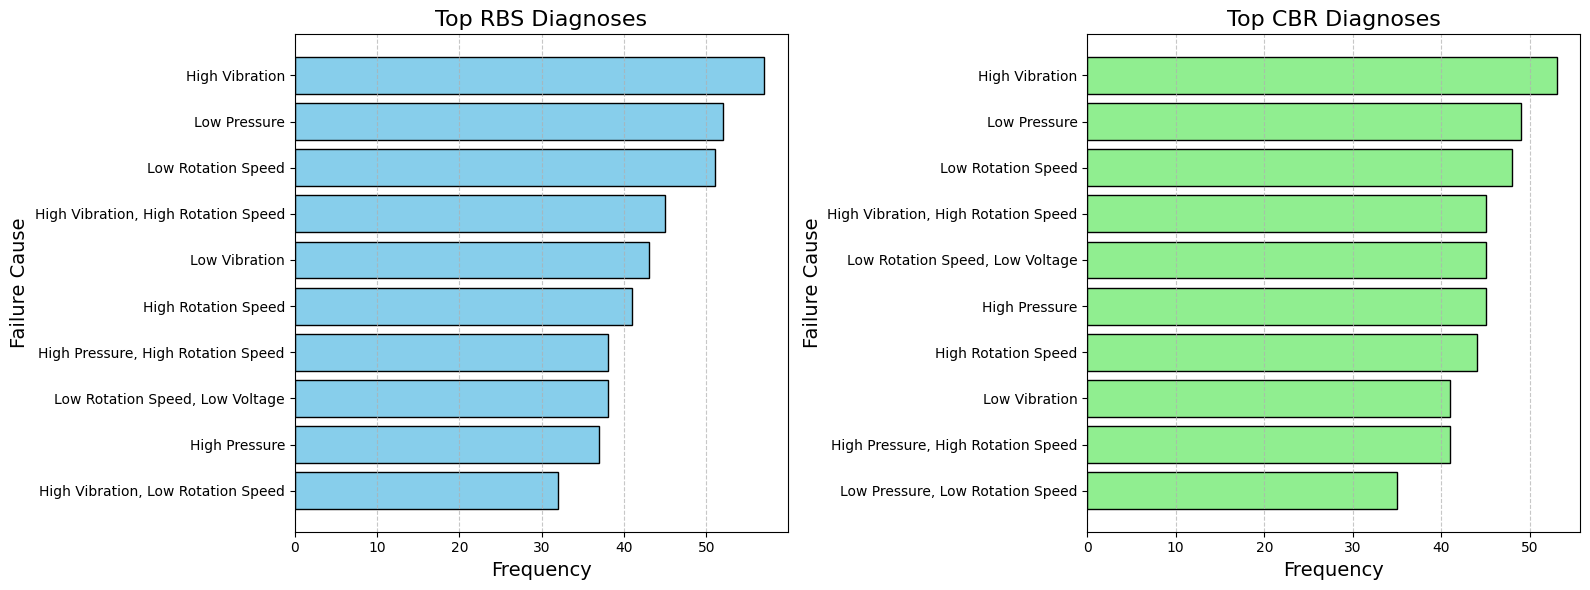

In [47]:
def visualize_two_separate_charts(data, rbs_column='RBS_Diagnosis', cbr_column='CBR_Diagnosis', top_n=10):
    """
    Creates two independent bar charts side-by-side for RBS and CBR diagnoses,
    ensuring no empty fields and unique labeling.

    Parameters:
    - data: DataFrame containing the analysis results.
    - rbs_column: The column name containing RBS diagnosis information.
    - cbr_column: The column name containing CBR diagnosis information.
    - top_n: Number of top causes to display for each method.

    Returns:
    - Two separate bar charts displayed side-by-side.
    """
    # Filter and count the RBS diagnoses
    rbs_counts = data[(data[rbs_column].notna()) & (data[rbs_column] != 'No Issues')][rbs_column].value_counts().head(top_n)

    # Filter and count the CBR diagnoses
    cbr_counts = data[(data[cbr_column].notna()) & (data[cbr_column] != 'No Issues')][cbr_column].value_counts().head(top_n)

    # Create the figure and axes for two separate bar charts
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot the RBS diagnoses
    ax1.barh(rbs_counts.index, rbs_counts.values, color='skyblue', edgecolor='black')
    ax1.set_title('Top RBS Diagnoses', fontsize=16)
    ax1.set_xlabel('Frequency', fontsize=14)
    ax1.set_ylabel('Failure Cause', fontsize=14)
    ax1.invert_yaxis()
    ax1.grid(axis='x', linestyle='--', alpha=0.7)

    # Plot the CBR diagnoses
    ax2.barh(cbr_counts.index, cbr_counts.values, color='lightgreen', edgecolor='black')
    ax2.set_title('Top CBR Diagnoses', fontsize=16)
    ax2.set_xlabel('Frequency', fontsize=14)
    ax2.set_ylabel('Failure Cause', fontsize=14)
    ax2.invert_yaxis()
    ax2.grid(axis='x', linestyle='--', alpha=0.7)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# Call the function to create independent visualizations for RBS and CBR
visualize_two_separate_charts(rbs_results_dynamic, rbs_column='RBS_Diagnosis', cbr_column='CBR_Diagnosis')
